# Data for calibration


**Table of contents**<a id='toc0_'></a>    
- 1. [Download data](#toc1_)    
- 2. [National account](#toc2_)    
- 3. [Capital, employment and population](#toc3_)    
- 4. [Unemployment rate](#toc4_)    
- 5. [Steady state - aggregate](#toc5_)    
  - 5.1. [Save to disc](#toc5_1_)    
- 6. [Income and wealth over life-cycle](#toc6_)    
- 7. [Life-cyle profile of income](#toc7_)    
  - 7.1. [Predicted vs. observed income in year:](#toc7_1_)    
  - 7.2. [Save to disc](#toc7_2_)    
  - 7.3. [Predicted vs. observed income for cohort 1983:](#toc7_3_)    
- 8. [Wealth-income ratio:](#toc8_)    
  - 8.1. [Save to disc](#toc8_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm
import pickle

from linearmodels import PanelOLS # pip install linearmodels
from IPython.display import display
from dstapi import DstApi # the helper class. pip install git+https://github.com/alemartinello/dstapi

import matplotlib.pyplot as plt   
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## 1. <a id='toc1_'></a>[Download data](#toc0_)

In [2]:
NationalAccount = DstApi('NAN1')                # Unit : 2010-prices, chained values, bill. DKK
EmploymentPopuplation = DstApi('NAHB')          # Unit : number of people
Capital = DstApi('NAHD34')                      # Unit : m DKK
Unemployment = DstApi('AULAAR')                 # Unit : % of labour force

Income = DstApi('INDKP201')                     # Unit : DKK, fixed prices
Wealth = DstApi('FORMUE11')                     # Unit : DKK, fixed prices / Using 2014-definiion of net-wealth

FirstYear = 2000                                # Define first year of data (in cases where prior data exists)

## 2. <a id='toc2_'></a>[National account](#toc0_)

In [3]:
display(NationalAccount.tablesummary(language='en'))
display(NationalAccount.variable_levels('PRISENHED', language='en'))
display(NationalAccount.variable_levels('TRANSAKT', language='en'))

Table NAN1: Demand and supply by transaction, price unit and time
Last update: 2023-03-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LAN_C,"Pr. capita, 2010-prices, chained values, (1000...",False
2,Tid,57,1966,1966,2022,2022,True


,id,text
0,V_M,"Current prices, (bill. DKK.)"
1,LAN_M,"2010-prices, chained values, (bill. DKK.)"
2,L_V,Period-to-period real growth (per cent)
3,V_C,"Pr. capita. Current prices, (1000 DKK.)"
4,L_VB,"Contribution to GDP growth, (percentage point)"
5,LAN_C,"Pr. capita, 2010-prices, chained values, (1000..."


,id,text
0,B1GQK,B.1*g Gross domestic product
1,P7K,P.7 Imports of goods and services
2,P71K,P.71 Import of goods
3,P72K,P.72 Import of services
4,TFSPR,Supply
5,P6D,P.6 Exports of goods and services
6,P61D,P.61 Export of goods
7,P62D,P.62 Export of services
8,P31S1MD,P.31 Private consumption
9,P31S14D,P.31 Household consumption expenditure


**Create dataframe:**

In [4]:
params = {
    'table': 'NAN1',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B1GQK','P7K','P6D','P31S1MD','P3S13D','P5GD']},    # variables of interest
        {'code': 'PRISENHED', 'values': ['LAN_M']},                                         # 2010-prices, chained values (bill. DKK)
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}                                      # specified years    
        ]
    }
SupplyBalanceVar = NationalAccount.get_data(params=params).set_index(['TID']).sort_values(['TID'])

In [5]:
# a. components of GDP
Y = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'B.1*g Gross domestic product'].apply(pd.to_numeric)
M = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.7 Imports of goods and services'].apply(pd.to_numeric)
X = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.6 Exports of goods and services'].apply(pd.to_numeric)
C = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.31 Private consumption'].apply(pd.to_numeric)
G = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.3 Government consumption expenditure'].apply(pd.to_numeric)
I = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.5g Gross capital formation'].apply(pd.to_numeric)

# b. ratio of each component to GDP
SupplyBalanceDF = pd.DataFrame()
SupplyBalanceDF['M_ratio'] = M/Y
SupplyBalanceDF['X_ratio'] = X/Y
SupplyBalanceDF['C_ratio'] = C/Y
SupplyBalanceDF['G_ratio'] = G/Y
SupplyBalanceDF['I_ratio'] = I/Y

display(SupplyBalanceDF.head())

,M_ratio,X_ratio,C_ratio,G_ratio,I_ratio
TID,,,,,
2000,0.327152,0.415514,0.448724,0.245767,0.207608
2001,0.332289,0.425961,0.446067,0.248374,0.202839
2002,0.351816,0.442463,0.450409,0.252516,0.199482
2003,0.346878,0.435473,0.454647,0.252125,0.197361
2004,0.361965,0.436950,0.463449,0.249343,0.205254


## 3. <a id='toc3_'></a>[Capital, employment and population](#toc0_)

**Employment and population:**

In [6]:
display(EmploymentPopuplation.tablesummary())
display(EmploymentPopuplation.variable_levels('SOCIO', language='en'))

Table NAHB: Beskæftigelse og befolkning efter socioøkonomisk status og tid
Last update: 2023-04-21T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,SOCIO,3,EMPM_DC,Samlet antal beskæftigede (antal),POP,Gennemsnitsbefolkning,False
1,Tid,57,1966,1966,2022,2022,True


,id,text
0,EMPM_DC,Samlet antal beskæftigede (antal)
1,EMPM_NC,Beskæftigede med bopæl i Danmark
2,POP,Gennemsnitsbefolkning


In [7]:
params = {
    'table': 'NAHB',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'SOCIO', 'values': ['EMPM_DC','POP']},     # variables of interest
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
EmploymentPopuplationVar = EmploymentPopuplation.get_data(params=params).sort_values(['TID'])

**Capital:**

In [8]:
display(Capital.tablesummary(language='en'))
display(Capital.variable_levels('TRANSAKT', language='en'))

Table NAHD34: 3.1 Capital (full sequence) by transaction and time
Last update: 2022-09-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,17,B8GK,"B.8g Saving, gross",B9D,B.9 Net lending (+)/net borrowing (-),False
1,Tid,27,1995,1995,2021,2021,True


,id,text
0,B8GK,"B.8g Saving, gross"
1,D9K,"D.9r Capital transfers, receivable"
2,D91K,"D.91r Capital taxes, receivable"
3,D92K,"D.92r Investment grants, receivable"
4,D99K,"D.99r Other capital transfers, receivable"
5,D9D,"D.9p Capital transfers, payable"
6,D91D,"D.91p Capital taxes, payable"
7,D92D,"D.92p Investment grants, payable"
8,D99D,"D.99p Other capital transfers, payable"
9,P51C4D,P.51c Consumption of fixed capital


In [9]:
params = {
    'table': 'NAHD34',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B8GK']},           # variables of interest
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
CapitalVar = Capital.get_data(params=params).sort_values(['TID'])


**Create dataframe:**

In [10]:
# a. employment and population
L = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Employment (number)'].copy().set_index(['TID']).apply(pd.to_numeric)
N = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Population'].copy().set_index(['TID']).apply(pd.to_numeric)

# b. capital and employment ratio
CapitalEmploymentPopuplationDF = pd.DataFrame()
CapitalEmploymentPopuplationDF['K'] = CapitalVar[['TID','INDHOLD']].loc[CapitalVar['TRANSAKT'] == 'B.8g Saving, gross'].copy().set_index(['TID']).apply(pd.to_numeric)
CapitalEmploymentPopuplationDF['L_ratio'] = L/N 

display(CapitalEmploymentPopuplationDF.head())

,K,L_ratio
TID,,
2000,318423,0.516091
2001,343436,0.519381
2002,343526,0.517935
2003,351281,0.511855
2004,374174,0.507891


## 4. <a id='toc4_'></a>[Unemployment rate](#toc0_)

In [11]:
params = {
    'table': 'AULAAR',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'KØN', 'values': ['TOT']},                             # men and women in total
        {'code': 'PERPCT', 'values': ['L10']},                          # percent of the labour force 
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}                   # specified years
        ]
    }
UnemploymentVar = Unemployment.get_data(params=params).set_index(['TID']).sort_values(['TID'])

In [12]:
UnemploymentDF = pd.DataFrame()
UnemploymentDF['U'] = UnemploymentVar[['INDHOLD']].loc[UnemploymentVar['PERPCT'] == 'Per cent of the labour force'].copy()
UnemploymentDF = UnemploymentDF.apply(pd.to_numeric)

display(UnemploymentDF.head())

,U
TID,
2000,4.9
2001,4.7
2002,4.8
2003,5.8
2004,5.8


## 5. <a id='toc5_'></a>[Steady state - aggregate](#toc0_)

In [13]:
frames = [SupplyBalanceDF, CapitalEmploymentPopuplationDF, UnemploymentDF]

In [14]:
all_variables =  pd.concat(frames, axis=1)
display(all_variables.head())

,M_ratio,X_ratio,C_ratio,G_ratio,I_ratio,K,L_ratio,U
TID,,,,,,,,
2000,0.327152,0.415514,0.448724,0.245767,0.207608,318423.0,0.516091,4.9
2001,0.332289,0.425961,0.446067,0.248374,0.202839,343436.0,0.519381,4.7
2002,0.351816,0.442463,0.450409,0.252516,0.199482,343526.0,0.517935,4.8
2003,0.346878,0.435473,0.454647,0.252125,0.197361,351281.0,0.511855,5.8
2004,0.361965,0.436950,0.463449,0.249343,0.205254,374174.0,0.507891,5.8


### 5.1. <a id='toc5_1_'></a>[Save to disc](#toc0_)

In [15]:
# a. aggregate steady state values
ss_aggregate = {}
means = all_variables.mean()
for i,mean in enumerate(means):
    print(f'{means.index[i]}: {mean:.2f}')
    ss_aggregate[str(means.index[i])] = mean

# b. save to dsic
with open('data/ss_aggregate.pickle', 'wb') as fp:
    pickle.dump(ss_aggregate, fp)

M_ratio: 0.45
X_ratio: 0.52
C_ratio: 0.46
G_ratio: 0.25
I_ratio: 0.21
K: 510030.82
L_ratio: 0.51
U: 3.93


## 6. <a id='toc6_'></a>[Income and wealth over life-cycle](#toc0_)

**Income:**

In [16]:
Income.tablesummary(language='en')

Table INDKP201: Main table for personal income statistics by type of income, sex, age, population, price unit, unit and time
Last update: 2022-11-24T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,INDKOMSTTYPE,39,100,1 Disposable income (2+30-31-32-35),290,Taxable income,False
1,KOEN,3,MOK,"Men and women, total",K,Women,False
2,ALDER,15,14TOT,"Total, 15 years and over",80-00,80 years and over,False
3,POPU,2,5000,All regardless of having the type of income,5020,Only people with the type of income,False
4,PRISENHED,2,005,Constant prices,006,Nominal prices,False
5,ENHED,5,0050,Mean (DKK),105,People (Number),False
6,Tid,26,1996,1996,2021,2021,True


In [17]:
params = {
    'table': 'INDKP201',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'INDKOMSTTYPE', 'values': ['100']},                        # disposable income (pre-tax income is 105) 
        {'code': 'KOEN', 'values': ['MOK']},                                # men and women in total
        {'code': 'ALDER', 'values': ['*']},	                                # all ages
        {'code': 'POPU', 'values': ['5000']},	                            # all regardless of having the type of income
        {'code': 'PRISENHED', 'values': ['005']},                           # fixed prices (latest data years price level - 2021)
        {'code': 'ENHED', 'values': ['0050']},                              # average DKK
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}
        ]
    }
DisposableIncomeVar = Income.get_data(params=params).sort_values(['TID'])

**Wealth**:

In [18]:
Wealth.tablesummary(language='en')

Table FORMUE11: Wealth by type of wealth, unit, age, sex, population and time
Last update: 2022-12-20T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,FORM1,46,FGNF2020,"Net Wealth, (2020-definition A+B+CX-D-E-F)",FGF4,F.4. Other debt to the public sector,False
1,ENHED,9,200,Median (Constant prices 2021-level),240,Number of people in population 31.12,False
2,ALDER,16,1802,18 years and over,9099,90 years and over,False
3,KØN,3,MOK,"Men and women, total",K,Women,False
4,POPU,2,5005,Entire population,5025,Only people with the selected type of wealth,False
5,Tid,8,2014,2014,2021,2021,True


In [19]:
params = {
    'table': 'FORMUE11',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'FORM1', 'values': ['FGNF2014']},              
        # net wealth (2014 definition: Real assets + Financial asset excluding unquoted shares + Pensions in total - Mortgage debt - Other loans - Study loans + Debt collection)
        {'code': 'ENHED', 'values': ['215']},                   # fixed prices - 2021
        {'code': 'ALDER', 'values': ['*']},	                    # all ages
        {'code': 'KØN', 'values': ['MOK']},                     # men and women in total
        {'code': 'POPU', 'values': ['5005']},	                # entire population	
        {'code': 'Tid', 'values':[f'>=2014<']}                  # first year for the data set is 2014
        ]
    }
WealthVar = Wealth.get_data(params=params).sort_values(['TID'])

**Create dataframe:**

In [20]:
IncomeDF = pd.crosstab(index=[DisposableIncomeVar['TID']],values = DisposableIncomeVar['INDHOLD'], aggfunc = sum, columns = str('DisInc: ') + DisposableIncomeVar['ALDER'])  # convert unique ages as columns for income
WealthDF = pd.crosstab(index=[WealthVar['TID']],values = WealthVar['INDHOLD'], aggfunc = sum, columns = str('Wealth: ') + WealthVar['ALDER'])                                # convert unique ages as columns for wealth
IncomeWealthDF =  pd.concat([IncomeDF,WealthDF], axis=1)                                                                                                                       # concatenate dataframes
display(IncomeWealthDF)

ALDER,DisInc: 15-19 years,DisInc: 20-24 years,DisInc: 25-29 years,DisInc: 30-34 years,DisInc: 35-39 years,DisInc: 40-44 years,DisInc: 45-49 years,DisInc: 50-54 years,DisInc: 55-59 years,DisInc: 60-64 years,...,Wealth: 45-49 years,Wealth: 50-54 years,Wealth: 55-59 years,Wealth: 60-64 years,Wealth: 65-69 years,Wealth: 70-74 years,Wealth: 75-79 years,Wealth: 80-84 years,Wealth: 85-89 years,Wealth: 90 years and over
TID,,,,,,,,,,,,,,,,,,,,,
2000,37000,121400,171500,209100,227400,233800,235500,236100,229700,201100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,36400,121000,171100,209400,229700,237000,237300,239200,234200,204600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,38300,121100,170900,210600,232100,241100,240400,240400,236700,208400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,37200,119500,170100,211800,233900,243900,242900,241000,240100,212600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,37100,122000,176400,222300,246400,256100,256900,254200,253900,224700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,37400,123100,177800,225200,250600,262700,263500,261000,262000,234600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,39600,125800,178600,226600,253800,267600,270400,267200,268300,243300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,41300,129100,180000,227100,254700,269700,272100,269600,270800,245800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,40600,127500,176700,220100,246300,259700,260100,259300,255900,233700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 7. <a id='toc7_'></a>[Life-cyle profile of income](#toc0_)

**Set up data for regression:**

In [21]:
# a. log income for regression
log_IncomeDF = np.log(IncomeDF)

# b. drop total income column
log_IncomeDF.drop('DisInc: Total, 15 years and over', axis=1, inplace=True)

# c. rename columns
col_dict = {f'DisInc: {i}-{i+4} years' : f'age{i}-{i+4}' for i in range(15,75+1,5)}
log_IncomeDF = log_IncomeDF.rename(columns = {'DisInc: 80 years and over':'age80>='})
log_IncomeDF.rename(columns = col_dict, inplace=True)

**Long format:**

In [22]:
log_IncomeDF = log_IncomeDF.reset_index()
long_df = pd.melt(log_IncomeDF, id_vars="TID", var_name="age_group", value_name="log_income")

**Add variables:**
- Age 
- Birth year
- Age squared  

In [23]:
# new variables
long_df['median_birth_year'] = 0
long_df['median_age_squared'] = 0
long_df['median_age'] = 0
long_df['id'] = 0

a = range(0,308+22,22)
b = range(17,82+5,5)

# the age of a group is the median age of that group, i.e. 17 for group age15-19
for i,j in zip(a,b):
    long_df.loc[i:i+22,['median_birth_year']] = long_df['TID'] - j
    long_df.loc[i:i+22,['median_age_squared']] = j**2
    long_df.loc[i:i+22,['median_age']] = j
    long_df.loc[i:i+22,['id']] = j

long_df.set_index(['id', 'TID'], inplace=True)

**Run regression:**

In [24]:
# dependent variable
dependent = long_df.log_income

# exogenous variables
exog = sm.add_constant(long_df[['median_birth_year','median_age_squared','median_age']])

In [25]:
mod = PanelOLS(dependent, exog, drop_absorbed=True)
res = mod.fit(cov_type='unadjusted')
res

Dep. Variable:,log_income,R-squared:,0.7842
Estimator:,PanelOLS,R-squared (Between):,0.7893
No. Observations:,308,R-squared (Within):,0.6612
Date:,"Sun, May 14 2023",R-squared (Overall):,0.7842
Time:,20:39:12,Log-likelihood,-10.099
Cov. Estimator:,Unadjusted,,
,,F-statistic:,368.29
Entities:,14,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(3,304)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,368.29


### 7.1. <a id='toc7_1_'></a>[Predicted vs. observed income in year](#toc0_)

In [26]:
year = 2010 # must be a year in the data, i.e. 2000-2021

**Predicted income:**

In [27]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((year-i)*res.params.median_birth_year + res.params.const + res.params.median_age*i + res.params.median_age_squared*i**2))

**Observed income:**

In [28]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df.index.get_level_values(1) == year, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2010,age15-19,10.460242,1993,289,17,34900.0
22,2010,age20-24,11.702719,1988,484,22,120900.0
27,2010,age25-29,12.109562,1983,729,27,181600.0
32,2010,age30-34,12.375815,1978,1024,32,237000.0
37,2010,age35-39,12.507658,1973,1369,37,270400.0
42,2010,age40-44,12.561297,1968,1764,42,285300.0
47,2010,age45-49,12.569326,1963,2209,47,287600.0
52,2010,age50-54,12.555673,1958,2704,52,283700.0
57,2010,age55-59,12.532855,1953,3249,57,277300.0


**Plot:**

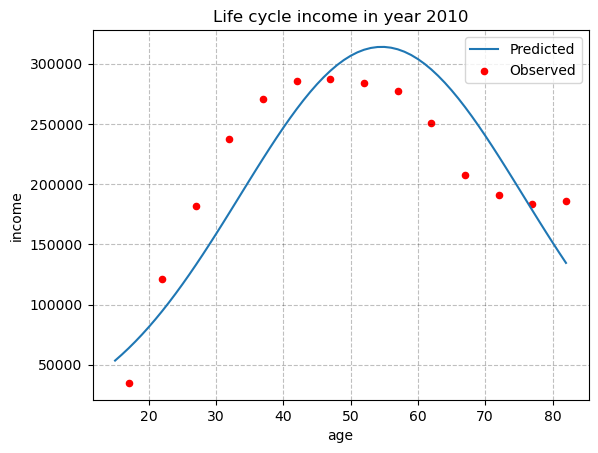

In [29]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income in year ' + str(year))
plt.ylabel('income')
plt.xlabel('age')
plt.legend()
plt.show()

### 7.2. <a id='toc7_2_'></a>[Save to disc](#toc0_)

In [30]:
## a. household income
ss_households_income = {}
ss_households_income['age'] = obs_income['median_age'].to_numpy()[1:] # drop the first element
ss_households_income['income'] = obs_income['income'].to_numpy()[1:] # drop the first element
ss_households_income['income'] /= ss_households_income['income'][0] # normalization

# b. save to disc
with open('data/ss_households_income.pickle', 'wb') as f:
    pickle.dump(ss_households_income, f)

### 7.3. <a id='toc7_3_'></a>[Predicted vs. observed income for cohort 1983](#toc0_)

**Predicted income for cohort 1983 (corrected for trend in time):**

In [31]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((1983)*res.params.median_birth_year + res.params.const + res.params.median_age*i + res.params.median_age_squared*i**2)) # birth year, 1983, remains constant

**Observed income for cohort 1983:**

In [32]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df['median_birth_year'] == 1983, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2000,age15-19,10.518673,1983,289,17,37000.0
22,2005,age20-24,11.720752,1983,484,22,123100.0
27,2010,age25-29,12.109562,1983,729,27,181600.0
32,2015,age30-34,12.369466,1983,1024,32,235500.0
37,2020,age35-39,12.623796,1983,1369,37,303700.0


**Plot:**

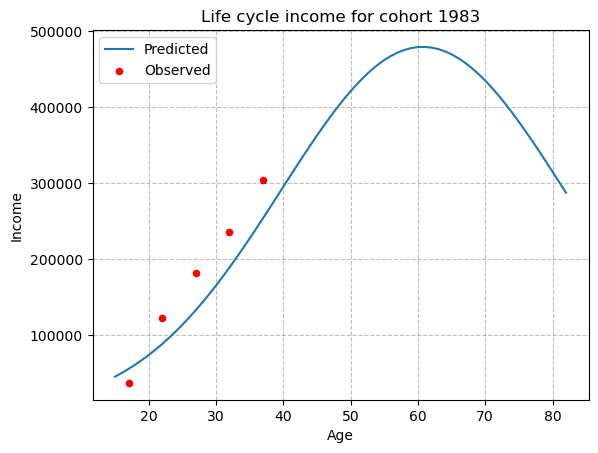

In [33]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income for cohort 1983')
plt.ylabel('Income')
plt.xlabel('Age')
plt.legend()
plt.show()

## 8. <a id='toc8_'></a>[Wealth-income ratio:](#toc0_)

**Calculate the wealth-income ratio based on the raw data:**

In [34]:
# a. get the relevant data frame
IncomeWealthDF =  pd.concat([IncomeDF,WealthDF], axis=1)

ages = []

# b. loop over age groups common to income and wealth data
for i in range(25,75+1,5):
    IncomeWealthDF['age_' + str(i) + '-' + str(i+4)] = IncomeWealthDF['Wealth: ' + str(i) + '-' + str(i+4) + ' years']/IncomeWealthDF['DisInc: ' + str(i) + '-' + str(i+4) + ' years']
    ages.append(i+2)

# c. the first age group, age_15-24
IncomeWealthDF['age_15-24'] = (IncomeWealthDF['DisInc: 15-19 years']+IncomeWealthDF['DisInc: 20-24 years'])/IncomeWealthDF['Wealth: 18-24 years'] # assuming no wealth for 15-17 years - no data ...
ages = [20] + ages

# d. wealth-income ratio for all age groups
IncomeWealthDF = IncomeWealthDF[['age_15-24']+['age_' + str(i) + '-' + str(i+4) for i in range(25,75+1,5)]]
IncomeWealthDF = IncomeWealthDF.dropna() # drop NANs - wealth data only available for 2014-2021

# e. take the mean over time for each age group
wealth_income_ratio = IncomeWealthDF.mean()
print(wealth_income_ratio)

ALDER
age_15-24     1.708060
age_25-29     0.890411
age_30-34     1.353253
age_35-39     2.105396
age_40-44     3.002130
age_45-49     3.944670
age_50-54     5.090315
age_55-59     6.610407
age_60-64     8.627028
age_65-69    10.806958
age_70-74    10.706063
age_75-79     9.618272
dtype: float64


**Linear interpolation of the observed wealth-income ratio:**

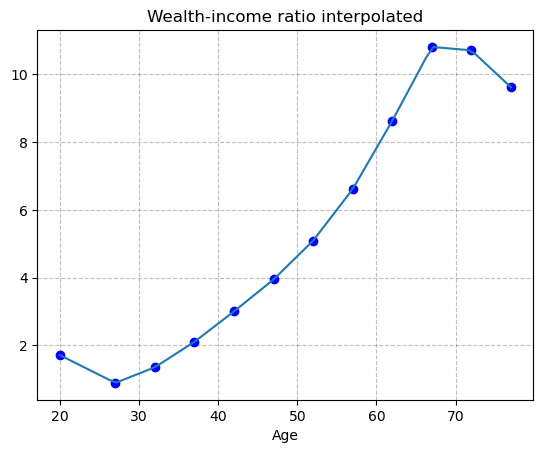

In [35]:
wealth_income_ratio_list = wealth_income_ratio.tolist()

ages_ = np.linspace(min(ages),max(ages),num=65) # num=65 => one dot for each age in 15-79
wealth_inc_interp = np.interp(ages_,ages,wealth_income_ratio_list)

plt.title('Wealth-income ratio interpolated')
plt.plot(ages,wealth_income_ratio_list,'bo')
plt.plot(ages_,wealth_inc_interp)
plt.xlabel('Age')
plt.show()

### 8.1. <a id='toc8_1_'></a>[Save to disc](#toc0_)

In [36]:
wealth_income_ratio.index.to_numpy()

array(['age_15-24', 'age_25-29', 'age_30-34', 'age_35-39', 'age_40-44',
       'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64', 'age_65-69',
       'age_70-74', 'age_75-79'], dtype=object)

In [37]:
## a. household income
ss_households_wealth = {}
ss_households_wealth['age'] = ages_
ss_households_wealth['wealth_income_ratio'] = wealth_inc_interp

# b. save to disc
with open('data/ss_households_wealth.pickle', 'wb') as f:
    pickle.dump(ss_households_wealth, f)